In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetmodified/dataset-modificado.csv
/kaggle/input/results-ann/resultados_ann.csv


## Visualización inicial de los datos
Hacemos una visualización inicial de los datos, observando que todos los datos están transfromados a datos numéricos. También eliminamos una columna que se nos creó cuando transformamos el dataset.

In [2]:
data=pd.read_csv("/kaggle/input/datasetmodified/dataset-modificado.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


## Dividimos el dataset
Tomamos la mitad de los datos para hacer validación cruzada

In [3]:
df = df.sample(frac=0.5)
df.shape

(159898, 17)

## Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [4]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

## Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [5]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

scaled_data=pd.DataFrame(s,columns=columns)
scaled_data.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-0.506566,1.192907,-0.270139,-0.198457,-0.423988,0.012308,-0.401630,1.054624,0.977983,-0.394789,-1.844679,-0.571018,-0.066475,-0.393974,-0.195528,-0.319315
1,0.721530,-0.838288,-0.270139,-0.198457,-0.423988,-0.490120,-0.401630,-0.948206,-0.143170,-0.394789,0.542100,-0.571018,3.398765,-0.393974,-0.195528,-0.319315
2,-0.316541,-0.838288,-0.270139,-0.198457,-0.298284,-0.113299,-0.401630,-0.948206,-0.703746,-0.394789,0.542100,0.388024,0.626573,2.538239,-0.195528,-0.319315
3,1.946486,1.192907,-0.270139,-0.198457,-0.423988,-0.490120,2.489853,-0.948206,1.538559,-0.394789,-1.844679,-1.530061,1.319621,-0.393974,-0.195528,3.131704
4,1.794152,-0.838288,-0.270139,-0.198457,0.707346,1.519591,-0.401630,1.054624,-1.824898,-0.394789,0.542100,0.388024,0.626573,-0.393974,-0.195528,-0.319315


## Validación Cruzada
Se utilizará StratifiedKFold con 3 folds. Se buscan los mejores parámetros donde se varía el número de capas ocultas y el número de neuronas. El número de capas ocultas serán 10, 20 y 30 y el número de neuronas 100, 200 y 300, se utilizarán como métrica de rendimiento

In [8]:
def ann(array_data_x, array_data_y, num_hidden_layers, num_neurons):
    folds = 3
    kf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx=0
    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            for j, (train, test) in enumerate(kf.split(X=array_data_x,y=array_data_y)):
                error_accuracy = np.zeros(folds)
                error_recall = np.zeros(folds)
                error_f1 = np.zeros(folds)
                Xtrain = array_data_x[train,:]
                Ytrain = array_data_y[train]
                Xtest = array_data_x[test,:]
                Ytest = array_data_y[test]
                hidden_layer_sizes = tuple(hidden_layers*[neurons])
                mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)
                mlp.fit(X=Xtrain,y=Ytrain)
                #Use para el modelo para hacer predicciones sobre el conjunto Xtest
                Yest = mlp.predict(X=Xtest)
                # recordar usar la medida adecuada de acuerdo a las instrucciones
                error_accuracy[j]=accuracy_score(y_true =Ytest, y_pred =Yest)
                error_recall[j]=recall_score(y_true =Ytest, y_pred =Yest)
                error_f1[j]=f1_score(y_true =Ytest, y_pred =Yest)
            resultados.loc[idx,'capas ocultas'] = hidden_layers
            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error accuracy de prueba(media)'] = np.mean(error_accuracy)
            resultados.loc[idx,'accuracy intervalo de confianza'] = np.std(error_accuracy)
            resultados.loc[idx,'error recall de prueba(media)'] = np.mean(error_recall)
            resultados.loc[idx,'recall intervalo de confianza'] = np.std(error_recall)
            resultados.loc[idx,'error f1 de prueba(media)'] = np.mean(error_f1)
            resultados.loc[idx,'f1 intervalo de confianza'] = np.std(error_f1)
            idx+=1
    return resultados

## Conversión del dataset
Transformamos el dataset a array para luego validar los mejores parámetros del modelo

In [6]:
array_data_x = np.array(scaled_data)
array_data_y = np.array(Y)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

## Número de capas ocultas y redes neuronales
Definimos un array para las diferentes capas ocultas y neuronas que vamos a probar

In [17]:
num_hidden_layers=[10,20,30]
num_neurons=[100,200,300]

## Se experimenta el modelo de redes neuronales
Se usa los array creados a partir del dataset con el número de capas ocultas y número de neuronas 

In [9]:
resultados = ann(array_data_x, array_data_y, num_hidden_layers, num_neurons)
resultados

,capas ocultas,neuronas en capas ocultas,error accuracy de prueba(media),accuracy intervalo de confianza,error recall de prueba(media),recall intervalo de confianza,error f1 de prueba(media),f1 intervalo de confianza
0,10.0,100.0,0.304834,0.431100,0.034827,0.049253,0.057803,0.081745
1,10.0,200.0,0.304715,0.430932,0.000000,0.000000,0.000000,0.000000
2,10.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
3,20.0,100.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
4,20.0,200.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
5,20.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
6,30.0,100.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
7,30.0,200.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
8,30.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000


## Se exporta los resultado a un archivo .csv

In [10]:
resultados.to_csv("resultados_ann.csv", encoding="utf-8")

## Se cargan los resultados

In [4]:
resultados_ann = pd.read_csv("/kaggle/input/results-ann/resultados_ann.csv")
resultados_ann=resultados_ann.drop(["Unnamed: 0"],axis=1)
resultados_ann

,capas ocultas,neuronas en capas ocultas,error accuracy de prueba(media),accuracy intervalo de confianza,error recall de prueba(media),recall intervalo de confianza,error f1 de prueba(media),f1 intervalo de confianza
0,10.0,100.0,0.304834,0.431100,0.034827,0.049253,0.057803,0.081745
1,10.0,200.0,0.304715,0.430932,0.000000,0.000000,0.000000,0.000000
2,10.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
3,20.0,100.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
4,20.0,200.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
5,20.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
6,30.0,100.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
7,30.0,200.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000
8,30.0,300.0,0.304721,0.430941,0.000000,0.000000,0.000000,0.000000


# Gráficas de rendimiento
## Accuracy, recall y f1 respecto al número de capas ocultas

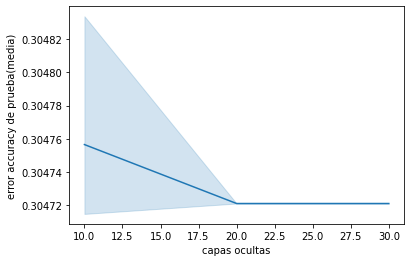

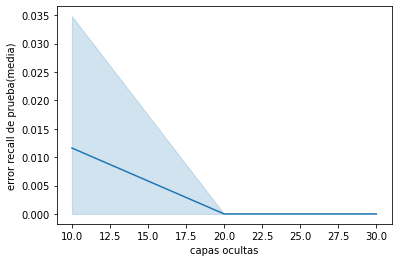

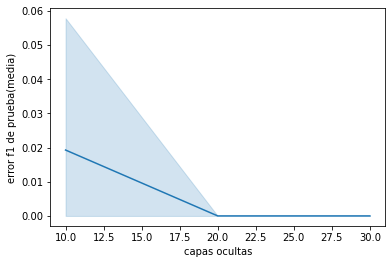

In [7]:
errores=["error accuracy de prueba(media)","error recall de prueba(media)","error f1 de prueba(media)"]
for error in errores:
    sns.lineplot(data=resultados_ann,x="capas ocultas",y=error)
    plt.show()

## Accuracy, recall y f1 respecto al número de neuronas

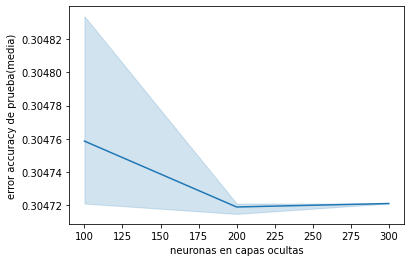

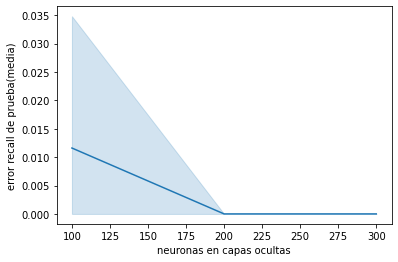

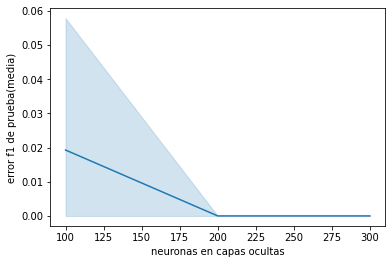

In [8]:
errores=["error accuracy de prueba(media)","error recall de prueba(media)","error f1 de prueba(media)"]
for error in errores:
    sns.lineplot(data=resultados_ann,x="neuronas en capas ocultas",y=error)
    plt.show()

## Se carga de nuevo el dataset, ya que se han realizado variaciones

In [5]:
data=pd.read_csv("/kaggle/input/datasetmodified/dataset-modificado.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


## Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [6]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

## Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [7]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

scaled_data=pd.DataFrame(s,columns=columns)
scaled_data.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-1.844750,1.193474,-0.27032,-0.198040,-0.046751,3.281069,-0.401578,-0.951711,0.136184,2.524911,0.538256,0.388307,-1.460354,2.541515,-0.195554,3.118419
1,-1.256338,-0.837890,-0.27032,5.049478,-0.424070,-0.490039,-0.401578,-0.951711,1.538806,-0.396054,0.538256,0.388307,-0.067601,-0.393466,-0.195554,-0.320675
2,-0.274603,1.193474,-0.27032,-0.198040,2.091388,3.281069,-0.401578,1.050739,0.697233,2.524911,0.538256,-1.529392,0.628776,2.541515,-0.195554,-0.320675
3,-0.647473,-0.837890,-0.27032,-0.198040,-0.424070,-0.490039,-0.401578,-0.951711,1.258282,-0.396054,-1.857852,-0.570542,-0.763977,-0.393466,-0.195554,3.118419
4,-0.726138,-0.837890,-0.27032,-0.198040,3.097572,-0.490039,2.490174,-0.951711,-0.705388,-0.396054,0.538256,0.388307,0.628776,-0.393466,-0.195554,-0.320675


## División de los datos
Se realiza una división de los datos en train y test de forma que quedaron 75% y 25% respectivamente

In [8]:
X_train,X_test,y_train,y_test=train_test_split(scaled_data,
                                               Y,
                                               test_size=0.25,
                                               random_state=50)

## Cantidad de datos que hay por clases para predecir

In [9]:
counter=Counter(y_train) 
print(counter)

Counter({0: 219314, 1: 20532})


## Función para el entrenamiento de los modelos

In [18]:
def entrenarModelo(model_train, Xtrain,Ytrain,Xtest,Ytest):
    model.fit(X=Xtrain,y=Ytrain)
    Ypred=model.predict(Xtest)

    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(Ytest,Ypred)}')
    print(f'Recall Score: {recall_score(Ytest,Ypred)}')
    print(f'F1-Score: {f1_score(Ytest,Ypred)}')
    cm = confusion_matrix(Ytest, Ypred, labels=model_train.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_train.classes_)
    disp.plot()
    return model_train

## Función para realizar el Submuestreo de los datos

In [19]:
def balancearClases(balanceador, X_train, y_train):
    Xtrain_new, Ytrain_new=balanceador.fit_resample(X_train,y_train)
    print("Dimensiones")
    print("Xtrain_new: ", Xtrain_new.shape)
    print("Ytrain_new: ", Ytrain_new.shape)
    return Xtrain_new,Ytrain_new

## Entrenamiento del modelo con Undersampling

In [12]:
subsample=RandomUnderSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (41064, 16)
Ytrain_new:  (41064,)


Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.6857246494640333
Precission Score: 0.1749795584627964
Recall Score: 0.7194854553427862
F1-Score: 0.2814984272233343


['ANN_UnderSampling.joblib']

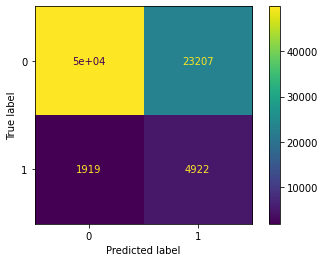

In [13]:
hidden_layer_sizes = tuple(10*[100])
model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'ANN_UnderSampling.joblib')

## Entrenamiento del modelo con Oversampling

In [14]:
subsample=RandomOverSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (438628, 16)
Ytrain_new:  (438628,)


Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.8060888816620596
Precission Score: 0.225015873015873
Recall Score: 0.5180529162403158
F1-Score: 0.313753264574388


['ANN_OverSampling.joblib']

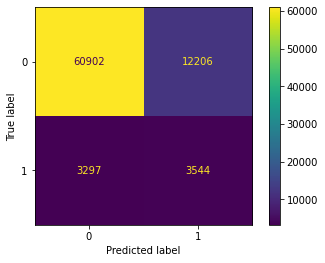

In [15]:
hidden_layer_sizes = tuple(10*[100])
model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'ANN_OverSampling.joblib')

## Entrenamiento del modelo sin usar técnicas de submuestreo

Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.9144329510062665
Recall Score: 0.0
F1-Score: 0.0


['ANN.joblib']

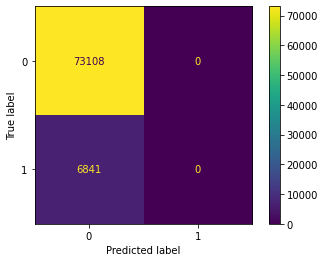

In [20]:
hidden_layer_sizes = tuple(10*[100])
model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)
joblib.dump(modelo_entrenado, 'ANN.joblib')